# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Цель проекта -  построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорты

In [1]:
# установим последнюю версию scikit-learn
# для OneHotEncoder работает одновременно drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3

In [70]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

# импорты модулей
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 42

# сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Загрузка данных

In [3]:
df = pd.read_csv('---.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных**

**Признаки**

....описание колонок...

**Целевой признак**

*Price* — цена (евро)

### Изучение даннх

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Описание количественных признаков:

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описание категориальных признаков:

In [6]:
df.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Количество пропусков в каждом столбце:

In [7]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Столбцы VehicleType, Gearbox, FuelType и Repaired обладают пропусками. 

Изучим данные в датасете.

In [8]:
def uniq_values(data):
    for column in data.columns:
        print('Уникальные значения столбца', column)
        print(sorted(data[column].dropna().unique()))

In [9]:
uniq_values(df.drop(['PostalCode', 'DateCrawled', 'LastSeen'],  axis=1))

Уникальные значения столбца Price
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 29, 30, 32, 33, 35, 38, 39, 40, 45, 47, 49, 50, 55, 58, 59, 60, 65, 66, 69, 70, 74, 75, 77, 79, 80, 85, 88, 89, 90, 95, 98, 99, 100, 101, 105, 106, 108, 110, 111, 112, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 135, 139, 140, 142, 145, 149, 150, 155, 156, 157, 158, 159, 160, 162, 165, 166, 169, 170, 173, 175, 177, 179, 180, 181, 185, 188, 189, 190, 192, 193, 195, 196, 198, 199, 200, 202, 205, 209, 210, 211, 215, 217, 219, 220, 222, 224, 225, 229, 230, 233, 235, 236, 238, 240, 243, 245, 248, 249, 250, 251, 252, 253, 255, 259, 260, 261, 263, 265, 266, 269, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 284, 285, 288, 289, 290, 293, 295, 298, 299, 300, 301, 305, 308, 309, 310, 315, 316, 319, 320, 321, 323, 325, 329, 330, 331, 332, 333, 335, 338, 339, 340, 341, 344, 345, 348, 349, 350, 355, 356, 359, 360, 365, 366, 368, 369, 370, 3

- В столбце **RegistrationYear** существуют некорректные значения года регистрации, например 1234 или 8000.
- В столбце **RegistrationMonth** есть знаечние месяца = 0, это некорректно.
- В столбце **Power** присутвует некорректное значение мощности. Согласоно википедии у серийных автомобилей наибольшая мощность - 1985 л.с. В датасете есть даже пятизначные значения мощности, это некорректно. 
- В столбце **NumberOfPictures** все строки заполенны нулями.

###  Преодобработка

Определим признаки, важные для модели. В признак, которые не важны для модели, можно будет не бороться с аномалиями и пропусками.

К значимым признакам отнесем следующие столбцы:

- **VehicleType** - Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
- **Gearbox** - Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
- **Power** -  Мощность  напрямую влияет на цену.
- **Kilometer** -  Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее  цена.
- **FuelType** -  Тип топлива определяет конструкцию двигателя внутреннего сгорания.
- **Brand** - Марка автомобиля показывает качество и надежность автомобиля.
- **Repaired** - Машина подвергалась изменениям и ее надежность ниже.
- **RegistrationYear** - Год регистрации определяет сколько уже лет машина на ходу. Соответвенно, чем больше возраст, тем меньше цена.
- **Model** - может влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость.

Сократим таблицу до важных стоблцов.

In [10]:
filtred_df = df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
display(filtred_df.head())
display(filtred_df.info())

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
0,NaN,manual,0,150000,petrol,volkswagen,NaN,1993,golf,480
1,coupe,manual,190,125000,gasoline,audi,yes,2011,NaN,18300
2,suv,auto,163,125000,gasoline,jeep,NaN,2004,grand,9800
3,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

Столбцы, требующие обработки и план действий:


 - **VehicleType** -  Восстановим пропущенные значения по популярному типу из столбца Model или Brand.
 - **Gearbox** -  Для всех NaN установим значение 'manual'.
 - **Power** -  Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
 - **FuelType** -  Восстановим пропущенные значения по популярному типу из столбца Model или Brand.
 - **Repaired** - Для всех NaN установим значение 'no'.
 - **RegistrationYear** - Скоректируем на основе реальных значений в машинах.
 - **Model** - Для всех NaN установим значение 'unknown'.

#### Price

Удалим записи, где цена  = 0 и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

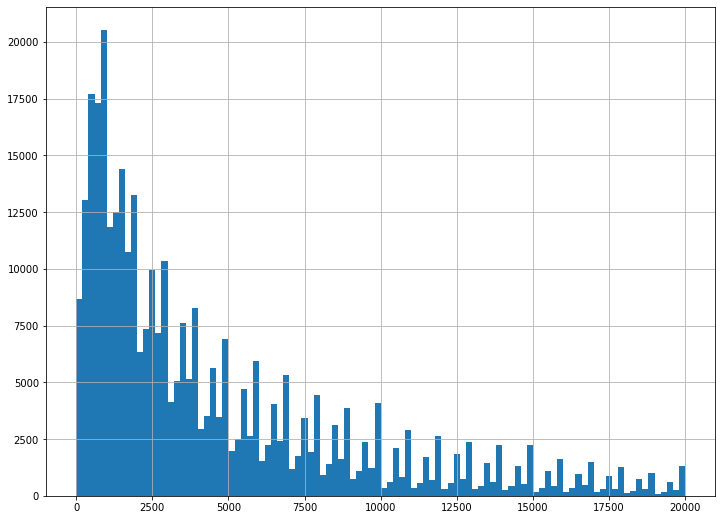

In [12]:
filtred_df = filtred_df.query('Price > 0')
filtred_df['Price'].hist(bins=100, figsize=(12,9))
filtred_df['Price'].describe()

In [13]:
filtred_df['Price'].quantile(0.10)

590.0

Отсечем данные по 10% квантилю. Это примерно 600 евро.

count    309241.000000
mean       5023.482847
std        4522.604779
min         590.000000
25%        1550.000000
50%        3390.000000
75%        7000.000000
max       20000.000000
Name: Price, dtype: float64

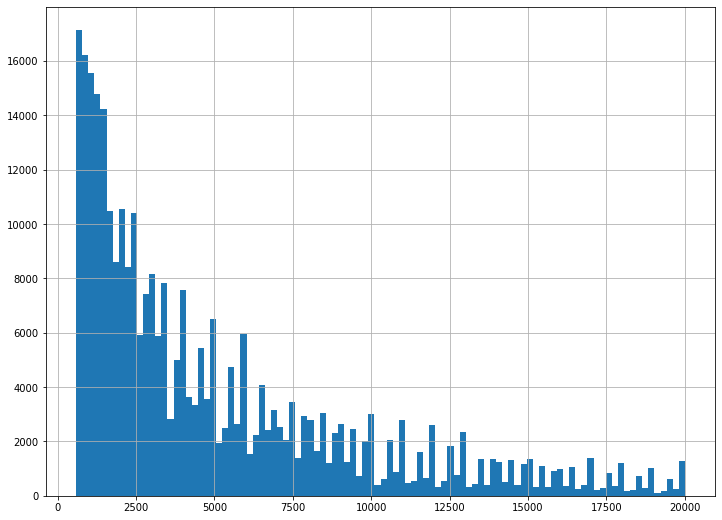

In [14]:
filtred_df = filtred_df.drop(filtred_df.query('Price < ' + filtred_df['Price'].quantile(0.10).astype('str')).index)
filtred_df['Price'].hist(bins=100, figsize=(12,9))
filtred_df['Price'].describe()

#### RegistrationYear

Проверим значения в столбце **RegistrationYear** на гистограмме.

count    309241.000000
mean       2004.283420
std          64.652955
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

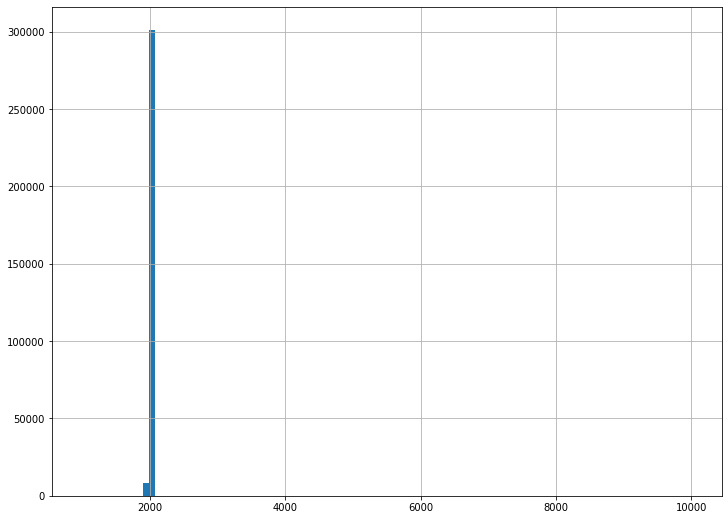

In [15]:
filtred_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_df['RegistrationYear'].describe()

Дата регистрации (RegistrationYear) автомобиля не может быть больше даты скачивания анкеты из базы (поле DateCrawled).

In [16]:
max_date = pd.to_datetime(df['DateCrawled'])
max_date.max()

Timestamp('2016-04-07 14:36:58')

За нижнюю границу возьмем 1890 год, примерно в этом время начали выпускать серийные автомобили. Оставим в датасете записи с 1890 по 2016 год регистрации.

count    296526.000000
mean       2003.031687
std           6.730946
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

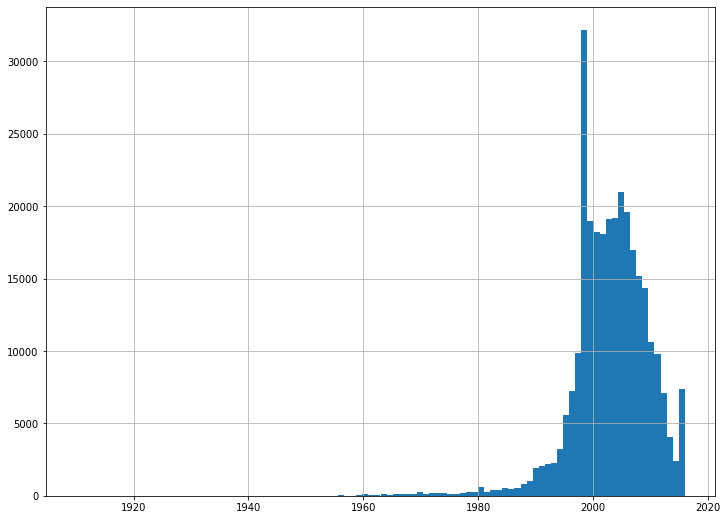

In [17]:
filtred_df = filtred_df.query('1889 < RegistrationYear < 2017')
filtred_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_df['RegistrationYear'].describe()

In [18]:
filtred_df['RegistrationYear'].quantile(0.05).astype('str')

'1993.0'

Судя по гистограмме, можем отсечь данные до 1960, они не попадают даже в 5% квантиль

count    296197.000000
mean       2003.089302
std           6.495731
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

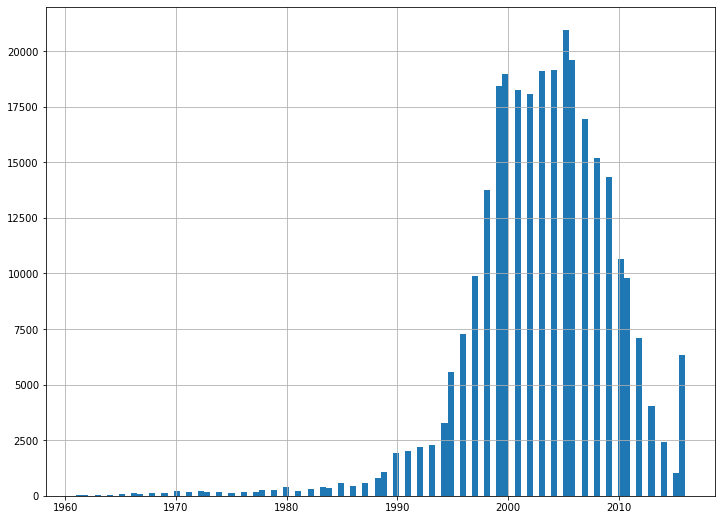

In [19]:
filtred_df = filtred_df.query('1960 < RegistrationYear')
filtred_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_df['RegistrationYear'].describe()

#### Gearbox, Repaired и Model

В соответсвии с планом произведем замены пропусков в столбцах:
 - **Gearbox** -  Для всех NaN установим значение 'manual'.
 - **Repaired** - Для всех NaN установим значение 'no'.
 - **Model** - Для всех NaN установим значение 'unknown'.

In [20]:
filtred_df.fillna({'Gearbox':'manual', 
                           'Repaired':'no',
                           'Model':'unknown'},
                          inplace=True)
filtred_df.isna().mean()

VehicleType         0.043660
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.057941
Brand               0.000000
Repaired            0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

#### VehicleType

Заменим  NaN в столбце с типом кузов на значение самого популярного типа кузова для данной модели.

Создадим сводную таблицу, чтобы определить самый популярный тип кузова для кажой модели.

In [21]:
vehicle_type_pivot_table = filtred_df.pivot_table(index= ['VehicleType'], 
                                                          columns=['Model'],
                                                          values=['Price'],
                                                          aggfunc=['count'])

display(vehicle_type_pivot_table)

count                                                           \
             Price                                                            
Model          100   145    147    156    159 1_reihe     1er   200 2_reihe   
VehicleType                                                                   
bus            NaN   NaN    NaN    NaN    NaN     4.0     NaN   NaN     1.0   
convertible    1.0   NaN    NaN    NaN    NaN     5.0   251.0   1.0  1494.0   
coupe          1.0   1.0   24.0    3.0    NaN     2.0   241.0   NaN    30.0   
other          NaN   NaN    6.0    NaN    NaN     1.0    20.0   NaN    10.0   
sedan        228.0  10.0  344.0  211.0   55.0    27.0  2632.0  15.0   176.0   
small          NaN  11.0   81.0    1.0    NaN   754.0   131.0   NaN  2280.0   
suv            NaN   NaN    NaN    NaN    NaN     NaN     NaN   NaN     3.0   
wagon         78.0   NaN    2.0  252.0  143.0    53.0    20.0   1.0   267.0   

                                                                         \
                                                                          
Model        300c 3_reihe     3er 4_reihe    500 5_reihe     5er    601   
VehicleType                                                               
bus           NaN    38.0     1.0     1.0   12.0   330.0     1.0    NaN   
convertible   NaN   480.0  2142.0     NaN  211.0    10.0     NaN   28.0   
coupe         NaN    43.0  2785.0   116.0    6.0     3.0     NaN    1.0   
other         NaN    13.0   145.0     1.0    8.0     1.0     3.0    2.0   
sedan        59.0  1272.0  7508.0   139.0   27.0    24.0  4310.0  107.0   
small         NaN   216.0   207.0     2.0  579.0     1.0     2.0   39.0   
suv           NaN     8.0     3.0    26.0    1.0     1.0     1.0    1.0   
wagon        69.0   682.0  4337.0   272.0    3.0    49.0  2928.0   40.0   

                                                                         \
                                                                          
Model       6_reihe    6er    7er     80    850    90   900  9000   911   
VehicleType                                                               
bus             2.0    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   
convertible     NaN   24.0    1.0  156.0    NaN   1.0  38.0   NaN  16.0   
coupe           8.0  107.0    NaN   46.0    NaN   5.0  22.0   1.0  41.0   
other           4.0    1.0    1.0    6.0    NaN   NaN   1.0   NaN   NaN   
sedan         452.0    4.0  906.0  679.0   14.0  61.0  29.0  19.0   NaN   
small           1.0    NaN    NaN    1.0    NaN   NaN   NaN   NaN   NaN   
suv             NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   
wagon         594.0    NaN    NaN  144.0  132.0   1.0   1.0   1.0   NaN   

                                                                          \
                                                                           
Model           a1     a2      a3      a4     a5      a6     a8 a_klasse   
VehicleType                                                                
bus            NaN    6.0     NaN     1.0    NaN     1.0    NaN     47.0   
convertible    NaN    NaN   150.0   532.0   37.0     NaN    NaN      1.0   
coupe          1.0    NaN   230.0     3.0  408.0     NaN    NaN     16.0   
other          NaN    6.0    61.0     6.0    3.0     3.0    NaN     26.0   
sedan         44.0   39.0  2781.0  3203.0   66.0  1766.0  478.0   2540.0   
small        525.0  289.0   559.0    61.0    NaN     1.0    NaN    789.0   
suv            NaN    NaN     1.0     1.0    NaN     7.0    NaN      2.0   
wagon          NaN    NaN  1405.0  5020.0    1.0  3267.0    1.0     10.0   

                                                                               \
                                                                                
Model       accord  agila alhambra almera  altea amarok antara  arosa   astra   
VehicleType                                                                     
bus            NaN   13.0

In [22]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,3_reihe,3er,4_reihe,500,5_reihe,5er,601,6_reihe,6er,7er,80,850,90,900,9000,911,a1,a2,a3,a4,a5,a6,a8,a_klasse,accord,agila,alhambra,almera,altea,amarok,antara,arosa,astra,auris,avensis,aveo,aygo,b_klasse,b_max,beetle,berlingo,bora,boxster,bravo,c1,c2,c3,c4,c5,c_klasse,c_max,c_reihe,caddy,calibra,captiva,carisma,carnival,cayenne,cc,ceed,charade,cherokee,citigo,civic,cl,clio,clk,clubman,colt,combo,cooper,cordoba,corolla,corsa,cr_reihe,croma,crossfire,cuore,cx_reihe,defender,delta,discovery,doblo,ducato,duster,e_klasse,elefantino,eos,escort,espace,exeo,fabia,fiesta,focus,forester,forfour,fortwo,fox,freelander,fusion,g_klasse,galant,galaxy,getz,gl,glk,golf,grand,i3,i_reihe,ibiza,impreza,insignia,jazz,jetta,jimny,juke,justy,ka,kadett,kaefer,kalina,kalos,kangoo,kappa,kuga,laguna,lancer,lanos,legacy,leon,lodgy,logan,lupo,lybra,m_klasse,m_reihe,materia,matiz,megane,meriva,micra,mii,modus,mondeo,move,musa,mustang,mx_reihe,navara,niva,note,nubira,octavia,omega,one,other,outlander,pajero,panda,passat,phaeton,picanto,polo,primera,ptcruiser,punto,q3,q5,q7,qashqai,r19,range_rover,range_rover_evoque,range_rover_sport,rangerover,rav,rio,roadster,roomster,rx_reihe,s60,s_klasse,s_max,s_type,samara,sandero,santa,scenic,scirocco,seicento,serie_1,serie_2,serie_3,sharan,signum,sirion,sl,slk,sorento,spark,spider,sportage,sprinter,stilo,superb,swift,terios,tigra,tiguan,toledo,touareg,touran,transit,transporter,tt,tucson,twingo,unknown,up,v40,v50,v60,v70,v_klasse,vectra,verso,viano,vito,vivaro,voyager,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
VehicleType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bus,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,38.0,1.0,1.0,12.0,330.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,1.0,NaN,47.0,NaN,13.0,314.0,97.0,265.0,NaN,1.0,NaN,1.0,NaN,12.0,NaN,NaN,610.0,25.0,NaN,519.0,NaN,NaN,NaN,NaN,NaN,40.0,142.0,1.0,NaN,501.0,NaN,497.0,NaN,NaN,NaN,221.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,172.0,2.0,NaN,32.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.0,258.0,NaN,3.0,NaN,NaN,2.0,413.0,NaN,2.0,8.0,88.0,1.0,NaN,NaN,NaN,NaN,6.0,NaN,1.0,901.0,NaN,NaN,NaN,756.0,103.0,NaN,37.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,519.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,30.0,10.0,3.0,NaN,1.0,NaN,1.0,NaN,59.0,782.0,1.0,NaN,171.0,1.0,11.0,14.0,NaN,1.0,NaN,NaN,92.0,NaN,NaN,NaN,NaN,3893.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,NaN,NaN,403.0,NaN,NaN,NaN,1.0,908.0,NaN,NaN,NaN,NaN,NaN,1117.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,471.0,NaN,NaN,NaN,NaN,1.0,3.0,5.0,8.0,2634.0,502.0,3922.0,NaN,1.0,NaN,843.0,NaN,NaN,NaN,NaN,NaN,131.0,3.0,269.0,235.0,683.0,246.0,224.0,NaN,3.0,1.0,NaN,NaN,42.0,NaN,NaN,NaN,2346.0
convertible,1.0,NaN,NaN,NaN,NaN,5.0,251.0,1.0,1494.0,NaN,480.0,2142.0,NaN,211.0,10.0,NaN,28.0,NaN,24.0,1.0,156.0,NaN,1.0,38.0,NaN,16.0,NaN,NaN,150.0,532.0,37.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,926.0,NaN,NaN,NaN,NaN,NaN,NaN,244.0,NaN,NaN,211.0,NaN,NaN,1.0,79.0,NaN,NaN,2.0,NaN,73.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,2.0,488.0,NaN,58.0,NaN,524.0,NaN,NaN,5.0,44.0,NaN,24.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,56.0,NaN,495.0,140.0,NaN,NaN,2.0,NaN,97.0,1.0,9.0,923.0,1.0,3.0,NaN,2.0,NaN,1.0,NaN,NaN,1.0,1819.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,170.0,30.0,99.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,23.0,NaN,NaN,539.0,NaN,44.0,NaN,NaN,NaN,NaN,NaN,42.0,892.0,NaN,NaN,NaN,1.0,NaN,NaN,124.0,1357.0,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,37.0,63.0,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,1.0,NaN,150.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,341.0,1172.0,NaN,NaN,176.0,NaN,NaN,NaN,NaN,5.0,NaN,388.0,NaN,NaN,NaN,2.0,NaN,NaN,393.0,NaN,1

Посчитаем значения для кажодго типа кузова перед заменой.

In [23]:
filtred_df['VehicleType'].value_counts()

sedan          83203
small          64993
wagon          59334
bus            27539
convertible    19376
coupe          14513
suv            11635
other           2672
Name: VehicleType, dtype: int64

Создадим функцию fillna_by_model для заполнения пропущенных значений из сводной таблицы (предварительно пропущенные значения заполним 0)

In [24]:
def fillna_by_model(row, row_number, pivot_table):
    model = row[8]
    fill_value = row[row_number]
    if row[row_number] == 0:
        try:
            fill_value = pivot_table[model].idxmax()
        except:
            print('error', model)
    return fill_value

In [25]:
filtred_df.fillna({'VehicleType':0},inplace=True)

filtred_df['VehicleType'] = filtred_df.apply(
                                fillna_by_model, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
print('Осталось пропусков в типе кузова:', filtred_df['VehicleType'].isna().sum())
filtred_df['VehicleType'].value_counts()

Осталось пропусков в типе кузова: 0


sedan          90740
small          67353
wagon          60525
bus            28856
convertible    19539
coupe          14677
suv            11834
other           2673
Name: VehicleType, dtype: int64

#### FuelType

Заменим NaN в столбце с типом топлива на значение самого популярного типа топлива для данной модели.

In [26]:
filtred_df['FuelType'].value_counts()

petrol      180095
gasoline     93210
lpg           4807
cng            511
hybrid         216
other          115
electric        81
Name: FuelType, dtype: int64

Количество пропусков

In [27]:
filtred_df['FuelType'].isna().sum()

17162

Создадим сводную таблицу, чтобы определить самый популярный тип топлива для кажой модели.

In [28]:
fuel_type_pivot_table = filtred_df.pivot_table(index=['FuelType'], 
                                                          columns=['Model'],
                                                          values=['Price'],
                                                          aggfunc=['count'])

fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

Model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,3_reihe,3er,4_reihe,500,5_reihe,5er,601,6_reihe,6er,7er,80,850,90,900,9000,911,a1,a2,a3,a4,a5,a6,a8,a_klasse,accord,agila,alhambra,almera,altea,amarok,antara,arosa,astra,auris,avensis,aveo,aygo,b_klasse,b_max,beetle,berlingo,bora,boxster,bravo,c1,c2,c3,c4,c5,c_klasse,c_max,c_reihe,caddy,calibra,captiva,carisma,carnival,cayenne,cc,ceed,charade,cherokee,citigo,civic,cl,clio,clk,clubman,colt,combo,cooper,cordoba,corolla,corsa,cr_reihe,croma,crossfire,cuore,cx_reihe,defender,delta,discovery,doblo,ducato,duster,e_klasse,elefantino,eos,escort,espace,exeo,fabia,fiesta,focus,forester,forfour,fortwo,fox,freelander,fusion,g_klasse,galant,galaxy,getz,gl,glk,golf,grand,i3,i_reihe,ibiza,impreza,insignia,jazz,jetta,jimny,juke,justy,ka,kadett,kaefer,kalina,kalos,kangoo,kappa,kuga,laguna,lancer,lanos,legacy,leon,lodgy,logan,lupo,lybra,m_klasse,m_reihe,materia,matiz,megane,meriva,micra,mii,modus,mondeo,move,musa,mustang,mx_reihe,navara,niva,note,nubira,octavia,omega,one,other,outlander,pajero,panda,passat,phaeton,picanto,polo,primera,ptcruiser,punto,q3,q5,q7,qashqai,r19,range_rover,range_rover_evoque,range_rover_sport,rangerover,rav,rio,roadster,roomster,rx_reihe,s60,s_klasse,s_max,s_type,samara,sandero,santa,scenic,scirocco,seicento,serie_1,serie_2,serie_3,sharan,signum,sirion,sl,slk,sorento,spark,spider,sportage,sprinter,stilo,superb,swift,terios,tigra,tiguan,toledo,touareg,touran,transit,transporter,tt,tucson,twingo,unknown,up,v40,v50,v60,v70,v_klasse,vectra,verso,viano,vito,vivaro,voyager,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
FuelType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,1.0,NaN,4.0,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,39.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,29.0,NaN,NaN,17.0,10.0,NaN,NaN,1.0,1.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,6.0,NaN,1.0,3.0,16.0,15.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0
electric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gasoline,12.0,NaN,124.0,160.0,137.0,34.0,1605.0,NaN,545.0,79.0,755.0,4

In [29]:
filtred_df.fillna({'FuelType':0},inplace=True)

filtred_df['FuelType'] = filtred_df.apply(
                                fillna_by_model, 
                                args=[4, fuel_type_pivot_table],
                                axis=1)

print('Пропусков осталось:', filtred_df['FuelType'].isna().sum())
filtred_df['FuelType'].value_counts()

Пропусков осталось: 0


petrol      194067
gasoline     96400
lpg           4807
cng            511
hybrid         216
other          115
electric        81
Name: FuelType, dtype: int64

In [30]:
filtred_df.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

Пропусков не осталось.

#### Power

count    296197.000000
mean        117.294162
std         187.667799
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

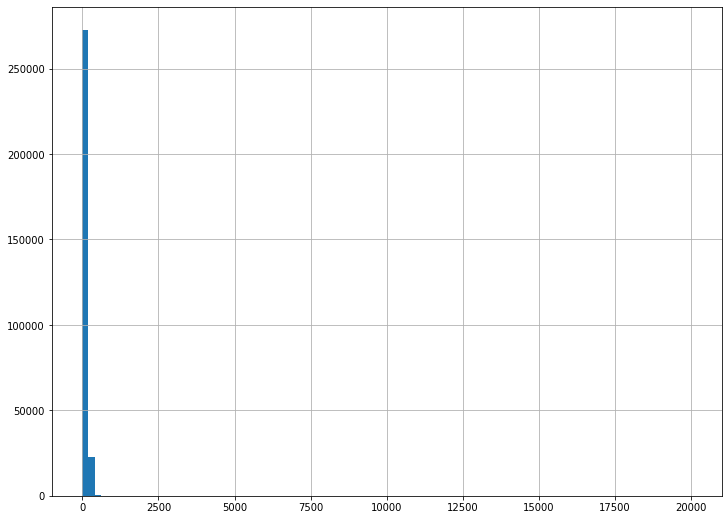

In [31]:
filtred_df['Power'].hist(bins=100, figsize=(12,9))
filtred_df['Power'].describe()

С данными по мощности что-то не так, видим, что есть неадекватные значения. Удалим сначала авто с небольшими ценами и большим количеством лошадиных сил, не относящиеся к премиальным брендам.

In [32]:
display(filtred_df.query('Power > 300 \
                         & Price < 3000 \
                         & Brand!="audi" \
                         & Brand !="bmw" \
                         & Brand!="mercedes_benz" \
                         & Brand!="porsche"').sort_values(by='Power').head(15))

filtred_df = filtred_df.drop(filtred_df.query('Power > 300 \
                            & Price < 3000 \
                            & Brand!="audi" \
                            & Brand !="bmw" \
                            & Brand!="mercedes_benz" \
                            & Brand!="porsche"').index)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
128896,other,manual,301,125000,petrol,daihatsu,no,1998,cuore,1000
143995,sedan,auto,305,150000,lpg,sonstige_autos,no,2001,unknown,1950
166372,sedan,auto,305,150000,petrol,sonstige_autos,no,2001,unknown,2500
197059,sedan,auto,305,150000,petrol,sonstige_autos,no,2000,unknown,2000
135363,sedan,auto,305,150000,petrol,sonstige_autos,no,1996,unknown,1890
252172,sedan,auto,305,150000,petrol,sonstige_autos,no,2001,unknown,2500
29128,sedan,auto,305,150000,petrol,sonstige_autos,no,1999,unknown,2750
2515,sedan,auto,305,150000,lpg,sonstige_autos,no,2001,unknown,1950
339815,sedan,auto,305,150000,petrol,sonstige_autos,yes,2000,unknown,2000
349763,coupe,auto,305,150000,petrol,sonstige_autos,no,1995,unknown,2000


count    296045.000000
mean        115.972953
std         163.234816
min           0.000000
25%          75.000000
50%         109.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

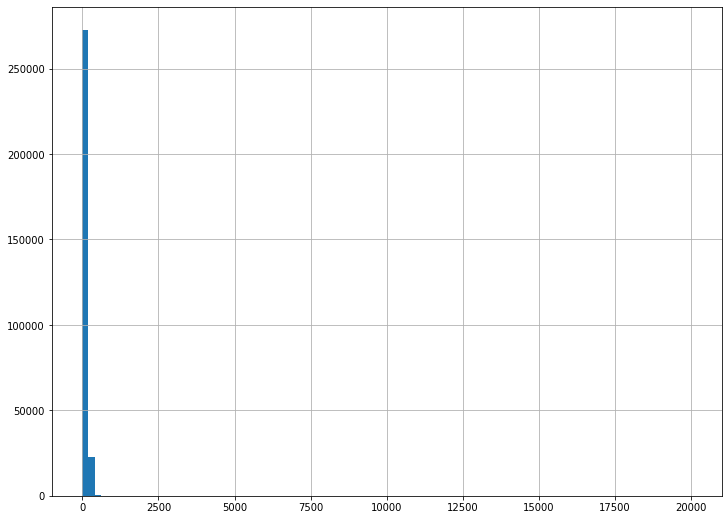

In [33]:
filtred_df['Power'].hist(bins=100, figsize=(12,9))
filtred_df['Power'].describe()

Отсечем значения более 500 л.с. и менее 30 л.с., это ненормальные значения для мощности автомобиля.

In [37]:
filtred_df = filtred_df.query('30 < Power < 500')

count    271282.000000
mean        124.062717
std          53.262043
min          31.000000
25%          84.000000
50%         116.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64

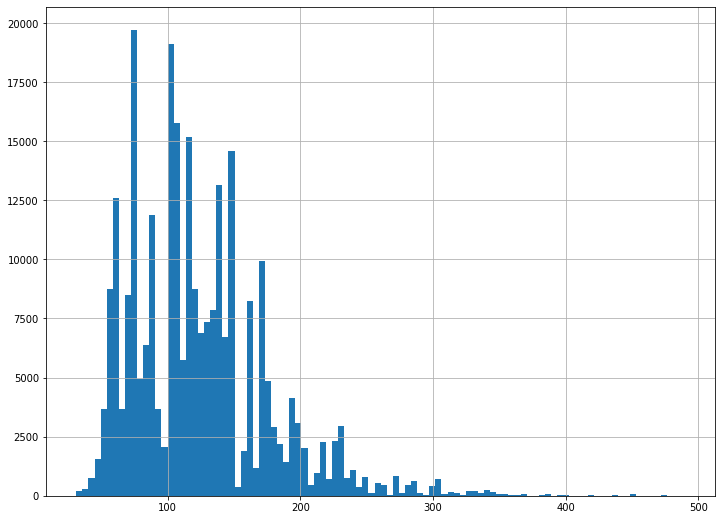

In [38]:
filtred_df['Power'].hist(bins=100, figsize=(12,9))
filtred_df['Power'].describe()

#### Kilometer

Изучим данные в столбце с пробегом.

count    271282.000000
mean     127532.586018
std       36930.905409
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

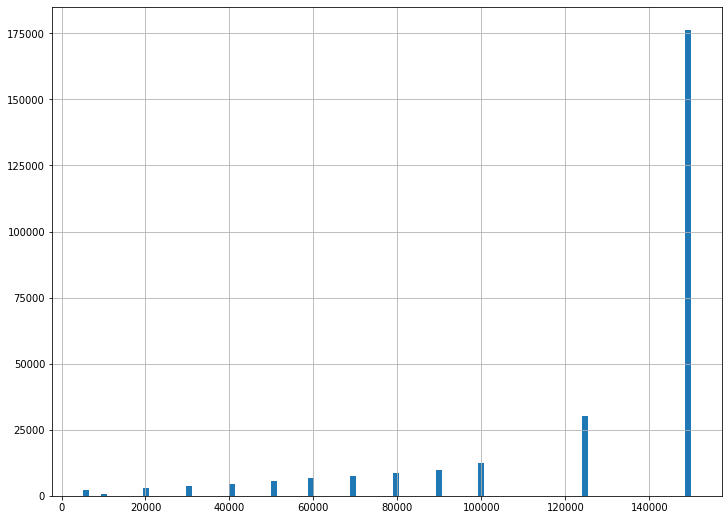

In [39]:
filtred_df['Kilometer'].hist(bins=100, figsize=(12,9))
filtred_df['Kilometer'].describe()

Пропусков нет, уникальных значений всего 13, больше всего по максимальному значению, возможно на сайте это предел, а у пользователей был километраж и 150000+, но ставили просто максимум сайта. Предобработка не требуется.

#### Дубликаты

In [40]:
print('Количество дубликатов до удаления:', filtred_df.duplicated().sum())
filtred_df.drop_duplicates(inplace = True)
print('Количество дубликатов после удаления:', filtred_df.duplicated().sum())

Количество дубликатов до удаления: 44131
Количество дубликатов после удаления: 0


### Вывод

- Была изучена таблица данных.
- Выведены аномальные и пропущенные значения.
- Отобраны небходимые столбцы для обучения модели.
- Заполнены пропуски в столбцах и удалены некорректные значения.
- Заменены два категориальных признака на численные.

In [41]:
print(f'При предобработке данных удалено {100 * (df.shape[0] - filtred_df.shape[0]) / df.shape[0]} % датасета')

При предобработке данных удалено 35.89986708769672 % датасета


## Обучение моделей

Обучим разные модели:

 - RandomForestRegressor (используем порядковое кодирование признака model, имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков)
 - Ridge (потребуется OHE кодирование категориальных признаков и StandardScaler для численных признаков)
 - CatBoost - градиентый бустинг
 - LightGBM - градиентый бустинг

Для оценки качества моделей будем использовать метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

Допустим, мы решили, что одной из моделей будет Ridge, для котрой будем использовать OHE кодирование категориальных признаков и StandardScaler для численных признаков. Второй моделью будет RandomForestRegressor, для которой будет использоваться порядковое кодирование признака model, имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков.

Разделим данные на обучающую и тестовую выборки.

In [42]:
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227151 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       227151 non-null  object
 1   Gearbox           227151 non-null  object
 2   Power             227151 non-null  int64 
 3   Kilometer         227151 non-null  int64 
 4   FuelType          227151 non-null  object
 5   Brand             227151 non-null  object
 6   Repaired          227151 non-null  object
 7   RegistrationYear  227151 non-null  int64 
 8   Model             227151 non-null  object
 9   Price             227151 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.1+ MB


In [43]:
features = filtred_df.drop(['Price'], axis=1)
target = filtred_df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(170363, 9)
(56788, 9)
(170363,)
(56788,)


### Ridge

Для модели `Ridge` используем OHE кодирование категориальных признаков и StandardScaler для численных признаков.

In [45]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']


In [46]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [47]:
#численные признаки для  Ridge
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['Power', 'Kilometer', 'RegistrationYear']

In [48]:
%%time

# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ridge[ohe_features_ridge])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

# смотрим на результат
X_train_ridge.head()

CPU times: user 44.1 s, sys: 1.99 s, total: 46.1 s
Wall time: 46.3 s


,Power,Kilometer,RegistrationYear,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira
7347,0.643596,0.633472,-1.317662,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,

In [49]:
%%time
# энкодером, который обучен на обучающей выборке, кодируем тестовую

X_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ridge[ohe_features_ridge])

X_test_ridge = X_test_ridge.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на обучающей выборке, масштабируем тестовую
X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)

# смотрим на результат
print(X_test_ridge.head())

           Power  Kilometer  RegistrationYear  VehicleType_convertible  \
193779 -0.942818   0.633472         -0.533663                      0.0   
29718  -0.942818  -2.544569          1.818336                      0.0   
115137  1.128852  -0.690712          0.563937                      0.0   
122990  1.259497   0.633472         -1.160862                      0.0   
308393 -1.222773  -0.028620          0.407137                      0.0   

        VehicleType_coupe  VehicleType_other  VehicleType_sedan  \
193779                0.0                0.0                0.0   
29718                 0.0                0.0                0.0   
115137                0.0                0.0                0.0   
122990                0.0                0.0                0.0   
308393                0.0                0.0                0.0   

        VehicleType_small  VehicleType_suv  VehicleType_wagon  Gearbox_manual  \
193779                1.0              0.0                0.0          

In [50]:
# получилось одинаковое количество признаков
X_train_ridge.shape, X_test_ridge.shape

((170363, 306), (56788, 306))

In [51]:
# получились одинаковые признаки в тренировочной и тестовой выборках
(X_train_ridge.columns != X_test_ridge.columns).sum()

0

Обучим модель.

In [52]:
%%time

model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами
param_grid_ridge = {
    'alpha': np.arange(0, 0.81, 0.2), #np.arange(0, 1.51, 0.01),
    'solver':['auto'] # 'svd', 'cholesky']

}
#для уменьшения времени расчеа при повторном запуске 
#оставляю только гиперпараметры с лучшим результатом  

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train_ridge, y_train)

CPU times: user 40.7 s, sys: 26.9 s, total: 1min 7s
Wall time: 1min 7s


GridSearchCV(estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'solver': ['auto']},
             scoring='neg_root_mean_squared_error')

Результаты обучения модели **Ridge**: время обучения, время предсказания и качество модели.

In [53]:
results_ridge = gs_ridge.cv_results_
best_index_ridge = gs_ridge.best_index_

ridge_fit_time = results_ridge['mean_fit_time'][best_index_ridge]
ridge_score_time = results_ridge['mean_score_time'][best_index_ridge]
ridge_RMSE = results_ridge['mean_test_score'][best_index_ridge] * -1

print(f"Fit time: {ridge_fit_time}, Predict time: {ridge_score_time}, Best RMSE: {ridge_RMSE}")

Fit time: 1.5774162769317628, Predict time: 0.17958974838256836, Best RMSE: 2672.271207829208


###  RandomForestRegressor

Для модели RandomForestRegressor исполузем порядковое кодирование признака `Model`, имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков.

In [54]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [55]:
#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf.remove('Model')
ohe_features_rf

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

In [56]:
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['Power', 'Kilometer', 'RegistrationYear']

In [57]:
%%time

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['Model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(250, 251, 50), # range(50, 251, 50),
    'randomforestregressor__max_depth': range(13, 15), # range(2, 15),
    'randomforestregressor__min_samples_split': (3, 4), # (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (2, 3) # (1, 2, 3, 4)
}

gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

CPU times: user 7h 20min 8s, sys: 1min 8s, total: 7h 21min 17s
Wall time: 7h 21min 33s


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['Model']),
                                                                              ('sta...
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(13, 15),
                                        'randomforestregressor__min_samples_leaf': (2,
                                                                                    3),
                                        'randomforestregressor__min_samples_split': (3,
                                                                                     4),
                                        'randomforestregressor__n_estimators': range(250, 251, 50)},
                   random_state=42, scoring='neg_root_mean_squared_error')

Результаты обучения модели **RandomForestRegressor**: время обучения, время предсказания и качество модели.

In [58]:
results_rf = gs_rf.cv_results_
best_index_rf = gs_rf.best_index_

rf_fit_time = results_rf['mean_fit_time'][best_index_rf]
rf_score_time = results_rf['mean_score_time'][best_index_rf]
rf_RMSE = results_rf['mean_test_score'][best_index_rf] * -1

print(f"Fit time: {rf_fit_time}, Predict time: {rf_score_time}, Best RMSE: {rf_RMSE}")

Fit time: 705.5553998470307, Predict time: 1.2449169635772706, Best RMSE: 1740.005568852735


### LightGBM

Преобразуем категориальные колонки в тип "category" для модели LightGBM.

In [59]:
categorial_columns = ['VehicleType','Gearbox', 'Model','FuelType', 'Brand', 'Repaired']
numerical_columns = ['Power','Age','Kilometer']

In [60]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

In [61]:
X_train_lgbm[categorial_columns] = X_train_lgbm[categorial_columns].astype('category')
X_test_lgbm[categorial_columns] = X_test_lgbm[categorial_columns].astype('category')

display(X_train_lgbm.info())
display(X_test_lgbm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170363 entries, 7347 to 176470
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       170363 non-null  category
 1   Gearbox           170363 non-null  category
 2   Power             170363 non-null  int64   
 3   Kilometer         170363 non-null  int64   
 4   FuelType          170363 non-null  category
 5   Brand             170363 non-null  category
 6   Repaired          170363 non-null  category
 7   RegistrationYear  170363 non-null  int64   
 8   Model             170363 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.3 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56788 entries, 193779 to 67984
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       56788 non-null  category
 1   Gearbox           56788 non-null  category
 2   Power             56788 non-null  int64   
 3   Kilometer         56788 non-null  int64   
 4   FuelType          56788 non-null  category
 5   Brand             56788 non-null  category
 6   Repaired          56788 non-null  category
 7   RegistrationYear  56788 non-null  int64   
 8   Model             56788 non-null  category
dtypes: category(6), int64(3)
memory usage: 2.1 MB


None

Обучим модель.

In [64]:
%%time
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

param_grid_lgbm = {
    'metric': ['rmse'],
    'boosting_type': ['gbdt'], #, 'dart']
    'n_estimators': [500, 750, 1000],
    'max_depth': [-1, 10, 18, 26],
}

gs_lgbm = GridSearchCV(
    model_lgbm, 
    param_grid=param_grid_lgbm,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)


gs_lgbm.fit(X_train_lgbm, y_train)

print(f'best_score: {gs_lgbm.best_score_ * -1}')
print(f'best_params: {gs_lgbm.best_params_}')
print(f'mean_fit_time: {gs_lgbm.cv_results_["mean_fit_time"].mean()}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best_score: 1597.8392886495453
best_params: {'boosting_type': 'gbdt', 'max_depth': 18, 'metric': 'rmse', 'n_estimators': 1000}
mean_fit_time: 342.0541154106458
CPU times: user 5h 40min 2s, sys: 2min 10s, total: 5h 42min 12s
Wall time: 5h 45min 5s


Результаты обучения модели **LightGBM**: время обучения, время предсказания и качество модели.

In [65]:
results_lgbm = gs_lgbm.cv_results_
best_index_lgbm = gs_lgbm.best_index_

lgbm_fit_time = results_lgbm['mean_fit_time'][best_index_lgbm]
lgbm_score_time = results_lgbm['mean_score_time'][best_index_lgbm]
lgbm_RMSE = results_lgbm['mean_test_score'][best_index_lgbm] * -1

print(f"Fit time: {lgbm_fit_time}, Predict time: {lgbm_score_time}, Best RMSE: {lgbm_RMSE}")

Fit time: 20.13375668525696, Predict time: 3.9465464115142823, Best RMSE: 1597.8392886495453


## Анализ моделей

Сравним результаты обучения моделей.

In [67]:
result = pd.DataFrame(
    [
     [ridge_RMSE, ridge_fit_time, ridge_score_time], 
     [rf_RMSE, rf_fit_time, rf_score_time], 
     [lgbm_RMSE, lgbm_fit_time, lgbm_score_time] ], 
    index=['Ridge', 'RandomForestRegressor', 'LightGBM'], 
    columns=['RMSE', 'fit_time', 'score_time']
)
result

,RMSE,fit_time,score_time
Ridge,2672.271208,1.577416,0.179590
RandomForestRegressor,1740.005569,705.555400,1.244917
LightGBM,1597.839289,20.133757,3.946546


Лучшие показатели у модели **LightGBM**, у этой модели самое низкое значение ошибки. Время обучения не самое короткое, но гораздо меньше, чем у RandomForestRegressor, второго по величине ошибки.  

Проверим модель на тестовой выборке.

In [68]:
mean_squared_error(y_test, gs_lgbm.predict(X_test_lgbm)) ** 0.5

1588.7102789900714

In [69]:
print(f'best_params: {gs_lgbm.best_params_}')

best_params: {'boosting_type': 'gbdt', 'max_depth': 18, 'metric': 'rmse', 'n_estimators': 1000}


Значение ошибки примерно соответствует ошибке на обучающей выборке.

##  Вывод

В ходе работы было выполнено:

1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.


Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать  **LightGBM**. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.